# Modelo basado en capas convolucionales para clasificación de dígitos

In [ ]:
INTEGRANTES:
JOAN ANDRES RINCON CHINCHILLA
FARID CAMILO PEDROZA FLORES
JUAN FELIPE GUERRA



 Modelo preentrenado (formato .h5):

In [2]:
import requests

url = "https://huggingface.co/spaces/ayaanzaveri/mnist/resolve/main/mnist-model.h5"
r = requests.get(url)
with open("mnist_model.h5", "wb") as f:
    f.write(r.content)

print("Modelo guardado correctamente.")

Modelo guardado correctamente.


Usar el modelo descargado

In [3]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2



# Cargar datos de prueba
(_, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Cargar el modelo preentrenado
model = load_model("mnist_model.h5")

# Carga el modelo con las metricas correctas

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


C:\Users\joari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\joari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Realizar una predicción

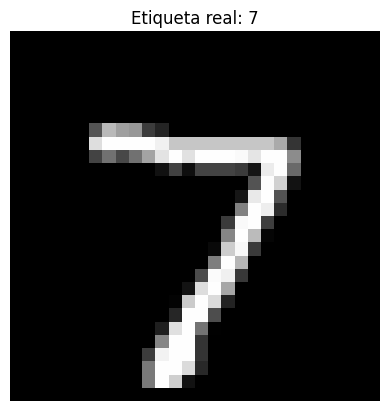

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Predicción del modelo: 7


In [4]:

idx = 0  # Cambia este índice para probar otras imágenes
img = x_test[idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Etiqueta real: {y_test[idx]}")
plt.axis('off')
plt.show()

prediction = model.predict(np.expand_dims(img, axis=0))
print("Predicción del modelo:", np.argmax(prediction))

# Para hacer

1. Mostrar los valores y visualizar al menos 10 kernels del modelo pre-entrenado
2. Mostrar las salidas obtenidas al aplicar la convolución de una imagen con los kernels del ejercicio 1.
3. Calcular las predicciones de al menos 10 imágenes propias (adjuntar evidencia del proceso de adquisición de imágenes). Aplicar y explicar el tratamiento de imágenes necesario para adecuar los datos de entrada al modelo.
4. Repetir el ejercicio 2 con al menos una de las imágenes del ejercicio 3.

Número de kernels: 64


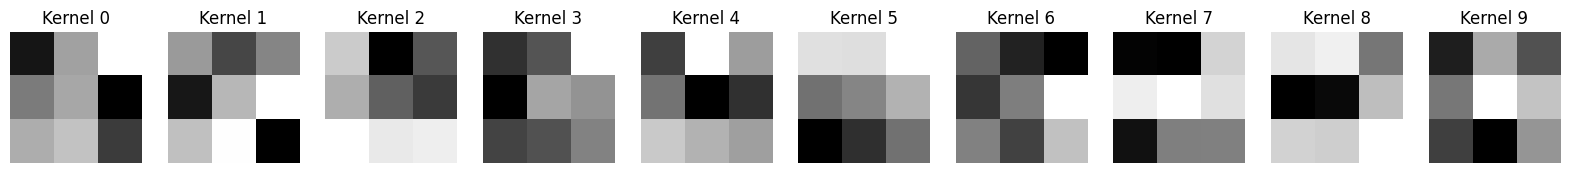

In [5]:
# === PASO 1: Mostrar 10 kernels de la primera capa convolucional ===
first_conv_layer = None
for layer in model.layers:
    if 'conv' in layer.name:
        first_conv_layer = layer
        break

if first_conv_layer:
    kernels, biases = first_conv_layer.get_weights()
    print(f"Número de kernels: {kernels.shape[-1]}")
    fig, axes = plt.subplots(1, 10, figsize=(20, 5))
    for i in range(10):
        kernel = kernels[:, :, 0, i]
        axes[i].imshow(kernel, cmap='gray')
        axes[i].set_title(f'Kernel {i}')
        axes[i].axis('off')
    plt.show()

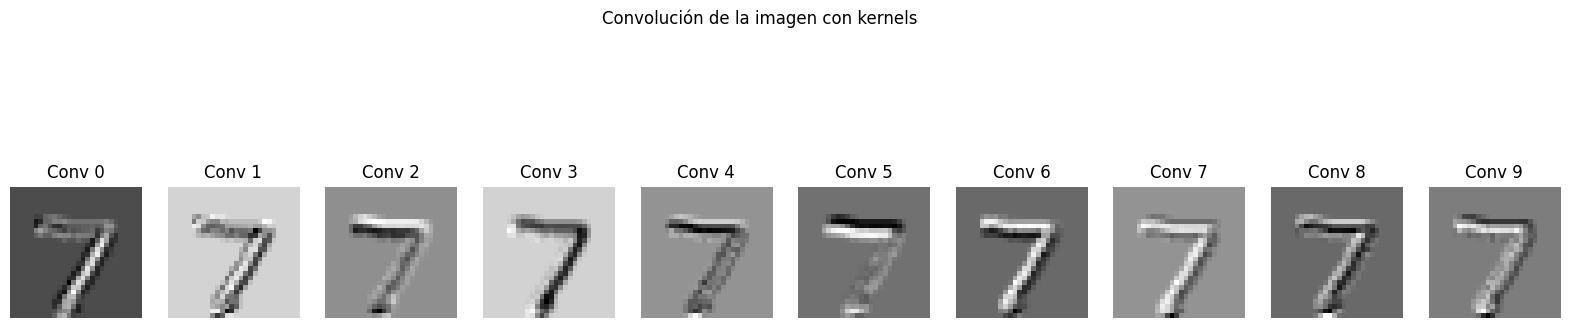

In [6]:
# === PASO 2: Aplicar convolución de una imagen de prueba con esos kernels ===
sample_image = x_test[0]  # Imagen de prueba
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    kernel = kernels[:, :, 0, i]
    output = cv2.filter2D(sample_image[:, :, 0], -1, kernel)
    axes[i].imshow(output, cmap='gray')
    axes[i].set_title(f'Conv {i}')
    axes[i].axis('off')
plt.suptitle("Convolución de la imagen con kernels")
plt.show()

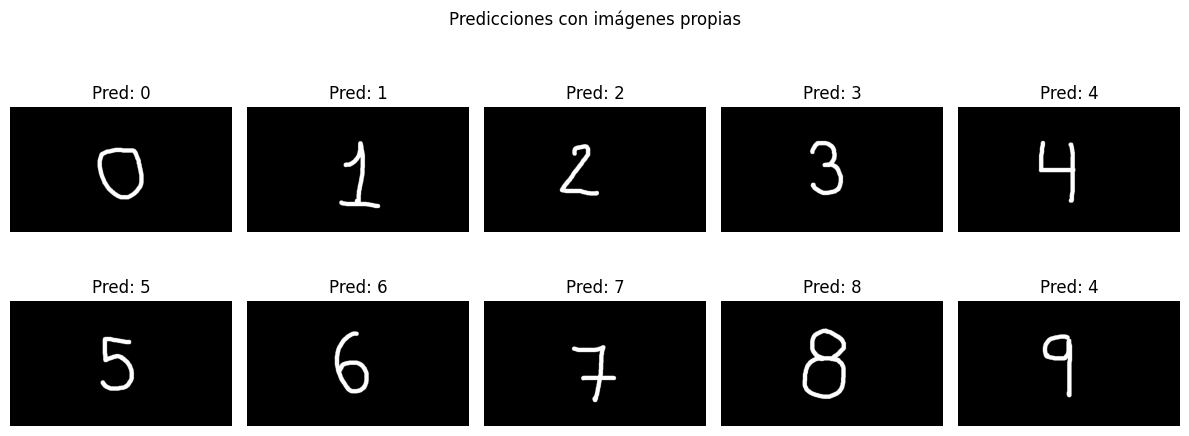

In [9]:
def preprocess_own_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Si la imagen no se carga, devuelve None
    if img is None:
        print(f"Error: No se pudo leer {img_path}")
        return None
    
    # Invertir si el fondo es blanco
    if np.mean(img) > 127:
        img = 255 - img
    
    # Binarización
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Encontrar el dígito (contorno más grande)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        digit = img[y:y+h, x:x+w]
    else:
        digit = img
    
    # Redimensionar y centrar en 28x28
    digit = cv2.resize(digit, (20, 20), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((28, 28), dtype=np.uint8)
    x_offset = (28 - 20) // 2
    y_offset = (28 - 20) // 2
    canvas[y_offset:y_offset+20, x_offset:x_offset+20] = digit
    
    # Normalizar para la red neuronal
    canvas = canvas.astype("float32") / 255.0
    canvas = canvas.reshape(1, 28, 28, 1)
    return canvas

# Procesar imágenes y mostrar resultados
plt.figure(figsize=(12, 5))
for i, filename in enumerate(own_images):
    path = os.path.join(own_folder, filename)
    img_processed = preprocess_own_image(path)
    
    if img_processed is not None:
        prediction = model.predict(img_processed, verbose=0)
        predicted_label = np.argmax(prediction)
        
        plt.subplot(2, 5, i + 1)
        img_show = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_show, cmap='gray')
        plt.title(f'Pred: {predicted_label}')
        plt.axis('off')
    else:
        print(f"⚠️ No se pudo procesar {filename}")

plt.suptitle("Predicciones con imágenes propias")
plt.tight_layout()
plt.show()

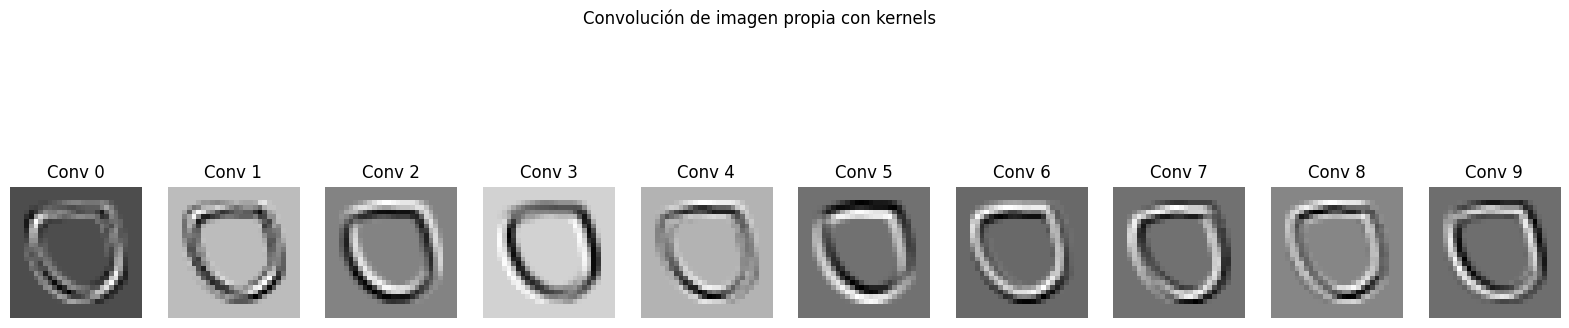

In [10]:
# === PASO 4: Aplicar convolución a una imagen propia ===
own_example = preprocess_own_image(os.path.join(own_folder, own_images[0]))
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    kernel = kernels[:, :, 0, i]
    output = cv2.filter2D(own_example[0, :, :, 0], -1, kernel)
    axes[i].imshow(output, cmap='gray')
    axes[i].set_title(f'Conv {i}')
    axes[i].axis('off')
plt.suptitle("Convolución de imagen propia con kernels")
plt.show()